# Classificazione binaria "selfMade" con ANN (MLPClassifier) utilizzando i parametri di GridSearch


In [15]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os

# Caricamento dati
X_train = pd.read_csv("../data/splitted/X_train.csv")
X_test = pd.read_csv("../data/splitted/X_test.csv")
y_train = pd.read_csv("../data/splitted/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/splitted/y_test.csv").values.ravel()

In [16]:
# Pulizia dei dati
X_train = X_train.drop(columns=['source'], errors='ignore')
X_train = X_train.loc[:, X_train.nunique() > 1]
X_test = X_test[X_train.columns]

In [29]:
# identificazione outlier
z_scores = np.abs((X_train - X_train.mean()) / X_train.std())
outliers = (z_scores > 3).any(axis=1)  # soglia z > 3

# Stampi quante righe sono outlier
print("Numero di outlier:", outliers.sum())
print("Numero di righe:", X_train.shape[0])


Numero di outlier: 1518
Numero di righe: 2081


In [17]:
# Standardizzazione
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Modello MLP
model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='tanh',
    alpha=1e-5,
    early_stopping=True,
    max_iter=300,
    random_state=42)
model.fit(X_train_scaled, y_train)

MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)

In [19]:
# Predizioni
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Metriche
train_metrics = {
    "Accuracy": accuracy_score(y_train, y_pred_train),
    "Precision": precision_score(y_train, y_pred_train),
    "Recall": recall_score(y_train, y_pred_train),
    "F1-Score": f1_score(y_train, y_pred_train),
    "Confusion Matrix": confusion_matrix(y_train, y_pred_train).tolist()
}
test_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_test),
    "Precision": precision_score(y_test, y_pred_test),
    "Recall": recall_score(y_test, y_pred_test),
    "F1-Score": f1_score(y_test, y_pred_test),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_test).tolist()
}

In [20]:
# Salvataggio risultati
output_dir = "../results/classification_selfMade/ann"
os.makedirs(output_dir, exist_ok=True)

filename = os.path.join(output_dir, "ann_metrics_gridsearch.txt")
with open(filename, "w") as f:
    f.write("Modello: MLPClassifier (2 hidden layer da 100, 50 neuroni, early stopping)\n\n")

    f.write("TRAIN METRICS:\n")
    for k, v in train_metrics.items():
        if k == "Confusion Matrix":
            f.write("Confusion Matrix:\n")
            f.write(f"{v}\n")
        else:
            f.write(f"{k}: {v:.4f}\n")

    f.write("\nTEST METRICS:\n")
    for k, v in test_metrics.items():
        if k == "Confusion Matrix":
            f.write("Confusion Matrix:\n")
            f.write(f"{v}\n")
        else:
            f.write(f"{k}: {v:.4f}\n")

print(f"✔ Metriche salvate in: {filename}")

✔ Metriche salvate in: ../results/classification_selfMade/ann\ann_metrics_gridsearch.txt


In [21]:
import matplotlib.pyplot as plt

plt.plot(model.loss_curve_)
plt.title("Loss durante il training (Due hidden layer da 100, 50)")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("../results/classification_selfMade/ann/loss_curve.png")
plt.close()

In [22]:
mean_train_loss = np.mean(model.loss_curve_)
std_train_loss = np.std(model.loss_curve_)
print(f"Media loss su training set: {mean_train_loss:.4f}")
print(f"Deviazione standard loss su training set: {std_train_loss:.4f}")

Media loss su training set: 0.3990
Deviazione standard loss su training set: 0.0655


In [23]:
from sklearn.metrics import log_loss


y_proba_test = model.predict_proba(X_test_scaled)

test_loss = log_loss(y_test, y_proba_test)

print(f"Loss sul test set: {test_loss:.4f}")


Loss sul test set: 0.5070


In [24]:
from sklearn.metrics import log_loss
y_proba_train = model.predict_proba(X_train_scaled)
print("Log-loss media su training set:", log_loss(y_train, y_proba_train))

Log-loss media su training set: 0.36127204950418523


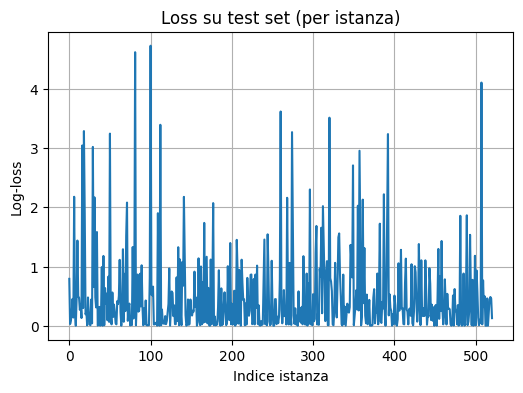

In [25]:
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np

# Probabilità predette sul test set
y_proba_test = model.predict_proba(X_test_scaled)

# Converto True/False in 1/0
y_test_int = y_test.astype(int)

# Calcolo della log-loss per ogni istanza
instance_losses = []
for p, true_label in zip(y_proba_test, y_test_int):
    prob = p[true_label]
    loss = -np.log(prob + 1e-15)  # epsilon per evitare log(0)
    instance_losses.append(loss)



# Grafico della loss
plt.figure(figsize=(6, 4))
plt.plot(instance_losses)
plt.title("Loss su test set (per istanza)")
plt.xlabel("Indice istanza")
plt.ylabel("Log-loss")
plt.grid(True)
plt.savefig("../results/classification_selfMade/ann/loss_curve_test_gridsearch.png")

In [26]:
print("Media log-loss sul test:", np.mean(instance_losses))
print("Deviazione standard sul test:", np.std(instance_losses))

Media log-loss sul test: 0.5070226222269726
Deviazione standard sul test: 0.7058593562400538


In [27]:
# Validazione incrociata CV
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_log_loss')
print("CV log-loss media:", -np.mean(scores))

CV log-loss media: 0.49970199694732464
